# Wine quality - Ridge and RidgeCV model

In [98]:
import pandas as pd
import numpy  as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib ipympl

In [99]:
df = pd.read_csv('winequality-red.csv')
df.head(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7


In [100]:
print(df.isna().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


**Correlations**

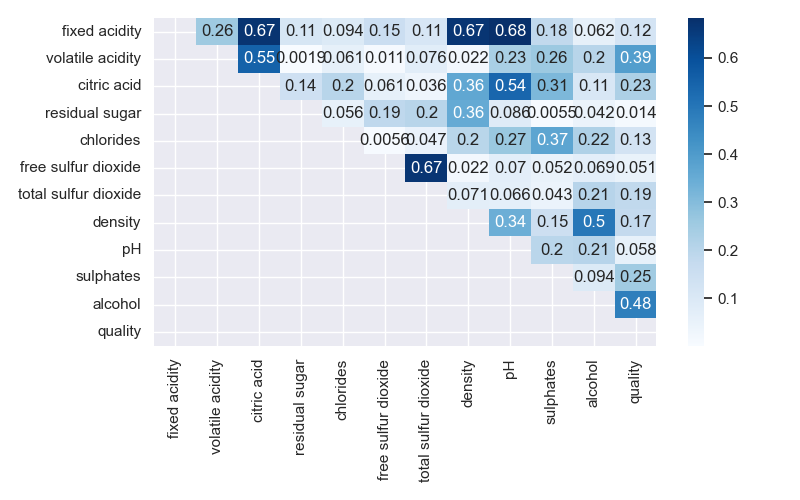

In [101]:
fig_1, ax_1 = plt.subplots(figsize=(8,5))
sns.heatmap(df.corr().abs(), cmap='Blues', annot=True, mask=np.tril(df.corr()))
plt.tight_layout()

In [102]:

qual_corr = df.corr().abs().sort_values(by='quality',ascending=False)
qual_corr['quality']


quality                 1.000000
alcohol                 0.476166
volatile acidity        0.390558
sulphates               0.251397
citric acid             0.226373
total sulfur dioxide    0.185100
density                 0.174919
chlorides               0.128907
fixed acidity           0.124052
pH                      0.057731
free sulfur dioxide     0.050656
residual sugar          0.013732
Name: quality, dtype: float64

Here the correlation between the features and the quality of the wines is very small for values bellow 0.1. Lets try with drop these features in the future.

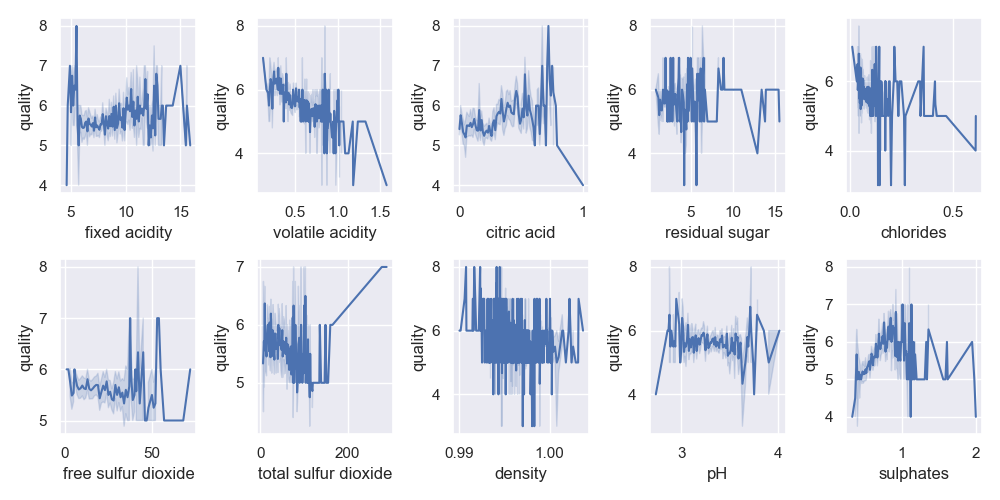

In [103]:
fig, axs = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.lineplot(data=df,x=df.columns[i],y='quality', ax=axs[0][i])
    sns.lineplot(data=df,x=df.columns[i+5],y='quality', ax=axs[1][i])
plt.tight_layout()

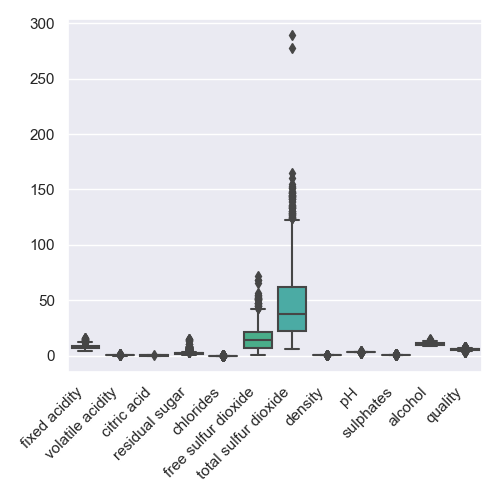

In [104]:
fig0, ax = plt.subplots(figsize=(5,5))
ax = sns.boxplot(data=df);

ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

**Empirical distribution**

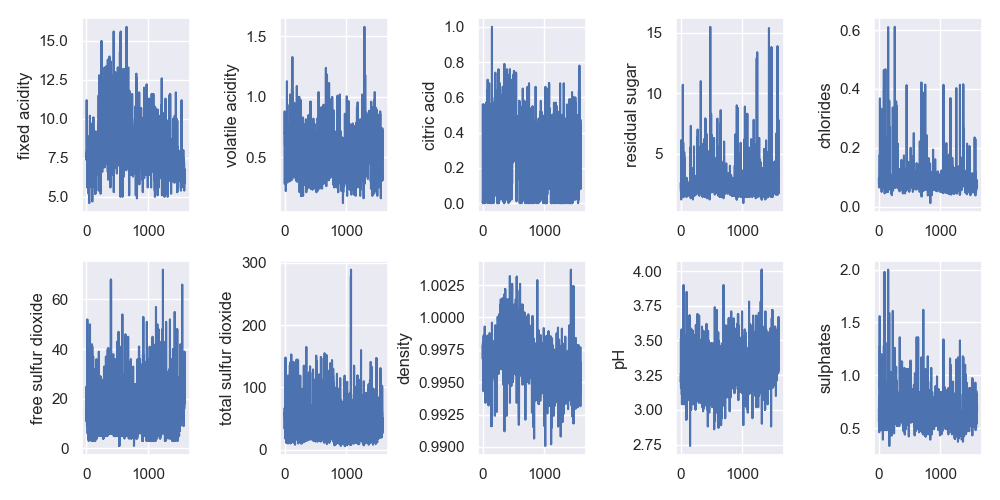

In [105]:
fig1, axs1 = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.lineplot(data=df,y=df.columns[i],x=df.index, ax=axs1[0][i])
    sns.lineplot(data=df,y=df.columns[i+5],x=df.index, ax=axs1[1][i])
plt.tight_layout()

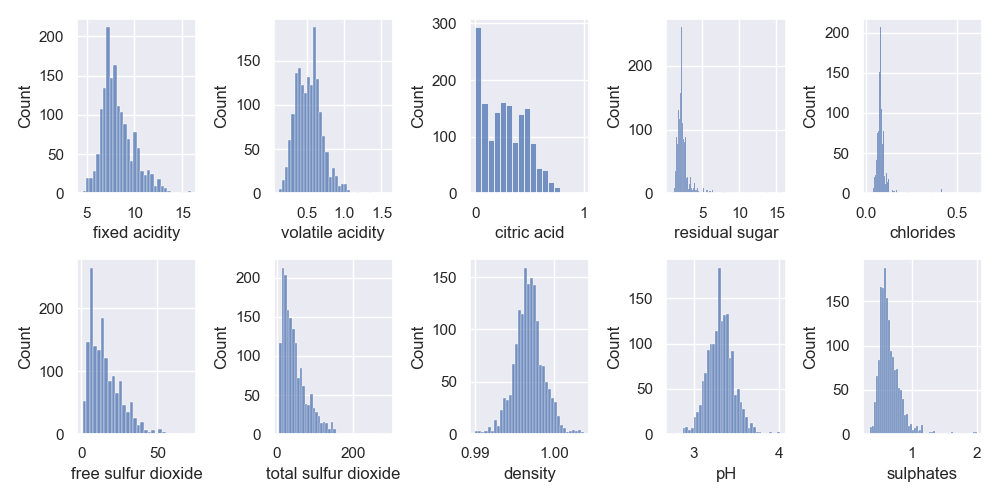

In [106]:
fig2, axs2 = plt.subplots(ncols=5,nrows=2,figsize=(10,5))
for i in range(len(df.columns)//2-1):
    sns.histplot(df[df.columns[i]],   ax=axs2[0][i])
    sns.histplot(df[df.columns[i+5]], ax=axs2[1][i])
plt.tight_layout()

The distributions seems to be all like Poisson distribution. It might be better to normalize (scale) the data frame because ``total sulfure dioxide`` feature is 2 orders the magnitude more than features like ``pH``, ``sulphates`` or ``citric acid``.

# Standard Scale

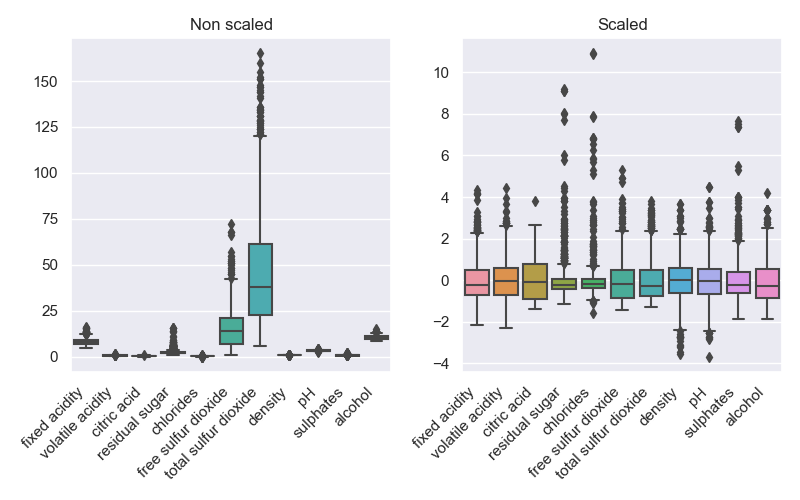

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = df.drop('quality',axis=1)
y = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

fig3, ax3 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= ax3[0]).set_title('Non scaled');
ax3[0].set_xticklabels(ax3[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=ax3[1]).set_title('Scaled');
ax3[1].set_xticklabels(ax3[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()


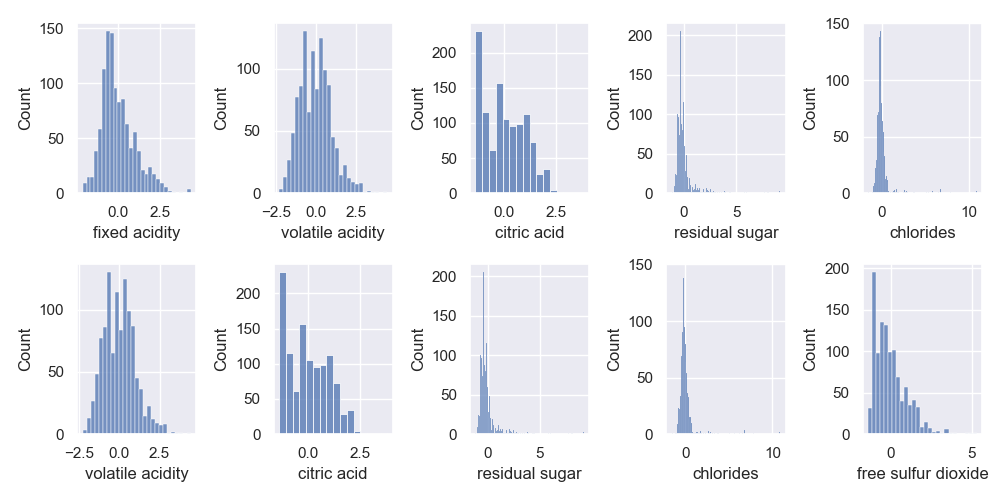

In [111]:
fig4, axs4 = plt.subplots(ncols=len(X.columns)//2,nrows=2,figsize=(10,5))

for i in range(len(df.columns)//2-1):
    sns.histplot(Xtrain_sc[Xtrain_sc.columns[i]],   ax=axs4[0][i])
    sns.histplot(Xtrain_sc[Xtrain_sc.columns[i+1]], ax=axs4[1][i])
plt.tight_layout()

# CV error

In [112]:
import sklearn.linear_model as lm
from sklearn.model_selection import KFold

def cv_error(x_train, y_train, k, method='OLS', alpha=1): #OLS: Regresión Lineal Ordinaria
    
    # Esta función calcula el error de validación cruzada y recopila 
    # los coeficientes de modelos de regresión regularizados en cada fold (k). 
    
    # Matriz de atributos y vector objetivo. 
    Xm, ym = x_train.values, y_train.values
    # dividimos el conjunto de entrenamiento en k particiones
    kf = KFold(n_splits=k)
    # Root Mean Squared Error Cross-Validation: Es una métrica que se utiliza para evaluar 
    # la calidad del modelo de regresión en cada fold de la validación cruzada y, 
    # finalmente, proporciona una medida general del rendimiento del modelo. Cuanto menor
    # sea el valor de rmse_cv, mejor será el rendimiento del modelo, ya que indicaría que
    # las predicciones del modelo se ajustan de manera más cercana a los datos reales.
    rmse_cv = 0
    # guardamos los coeficientes 
    coef_v = []

    # definimos el method_type en función del valor de method
    if method == 'OLS':
        method_type = lm.LinearRegression(fit_intercept=False)
    elif method == 'ridge':
        method_type = lm.Ridge(alpha=alpha, fit_intercept=False)
    elif method == 'lasso':
        method_type = lm.Lasso(alpha=alpha, fit_intercept=False)
    elif method == 'enet':
        method_type = lm.ElasticNet(alpha=alpha, fit_intercept=False)
    else:
        # Error de argumento invalido 
        raise TypeError("Method argument is not valid")

    # para cada partición del conjunto de entrenamiento
    for train_index, validation_index in kf.split(Xm):
        # definimos el método
        method_type = method_type
        # hacemos fit de los datos randomizados
        method_type.fit(Xm[train_index], ym[train_index])
        # agregamos los valores de los coeficientes
        coef_v.append(method_type.coef_)
        # predecimos los valores de validación
        yhat_validation = method_type.predict(Xm[validation_index])
        # reescribimos la metrica rmse para cada fold
        rmse_cv += np.mean(np.power(yhat_validation - ym[validation_index], 2))

    # creamos un df con los coeficientes
    coefs_dataframe = pd.DataFrame(
        # para cada array de coeficientes reordenamos los valores 
        [[fold[x] for x in range(x_train.shape[1])] for fold in coef_v]
    )

    # retorna los coeficientes y el rmse_cv
    coefs_dataframe.columns = list(x_train.columns)
    return coefs_dataframe, rmse_cv

# Ridge CV model

In [113]:
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

lambdas       = np.logspace(0,11,base=10)
coef_ridge    = [] #coefisisients of the ridge model
cv_err_ridge  = [] #errors of the ridge model

###################################################   Model
model_ridge = Ridge(fit_intercept=True)
tolerance   = 0.1
###################################################   Fitting
for ll in lambdas:
    # Parameter setting
    model_ridge.set_params(alpha=ll)
    # Fitting of the Model
    model_ridge.fit(Xtrain_sc,y_train)
    #Saving coefisients
    coef_ridge.append(model_ridge.coef_)
    
    _ , cv_err_estimates = cv_error(Xtrain_sc,y_train,k=10,method='ridge',alpha=ll)
    cv_err_ridge.append(np.mean(cv_err_estimates))

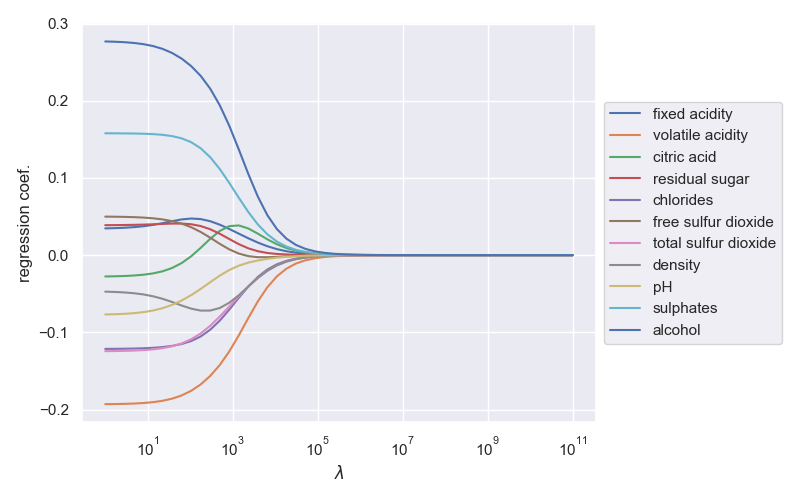

In [114]:
fig5, ax5 = plt.subplots(figsize=(8,5))
[ax5.plot(lambdas,y_arr,label = label)  for y_arr, label in zip(np.squeeze(coef_ridge).T,Xtrain_sc.columns)];
ax5.set_xscale("log")
ax5.set_ylabel('regression coef.')
ax5.set_xlabel(r'$\lambda$')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
plt.tight_layout()

# Ridge Results analysis

- All the coefficient go to zero for power of $\lambda$ above 5.
- The features shows similar decay in the coefficient values, except for **residual sugar** and **density** ones that oscilate when the power of $\lambda$ increases.

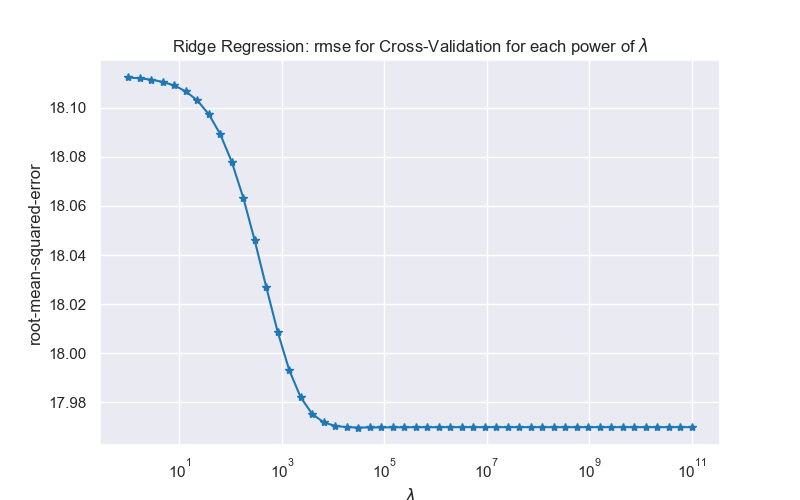

In [115]:
fig6, ax6 = plt.subplots(figsize=(8,5))

ax6.plot(lambdas, np.sqrt(cv_err_ridge),'*-',color='tab:blue')
ax6.set_xscale('log')
plt.title(r'Ridge Regression: rmse for Cross-Validation for each power of $\lambda$');
ax6.set_ylabel('root-mean-squared-error');
ax6.set_xlabel(r'$\lambda$');

It is clear that the power of lambda is good enough for values above 4 since the root mean squared error is minimum in these values.

# RIDGE-crossvalidation model

To find an optimized power of lambda automatically that minimizes the root mean squared error. 

In [116]:
lambdas = lambdas
ridgecv = RidgeCV(cv=7) 
ridgecv2 = RidgeCV(cv=7) 

#Scaled model
model_ridgecv = ridgecv.fit(Xtrain_sc,y_train) 
#nonscaled model
model_ridgecv_noscaled = ridgecv2.fit(X_train,y_train) 

**reularization report function**

In [117]:
def report_regularization (model, X_test, y_test,observation=''):
    print('\n{}'.format(observation))
    print( 'Regularization parameters values: {0}' .format(model.alpha_))
    print( 'Final coefficients: \n{0}' .format(model.coef_))
    y_hat = model.predict(X_test)
    print( 'R-squared: {0}' .format(r2_score(y_test,y_hat).round(2)))
    print( 'Mean Squared Error: {0}' .format(mean_squared_error(y_test, y_hat).round(2)))
    


In [118]:
#Ridge CV report
report_regularization(ridgecv,Xtest_sc,y_test,observation='****************** Scaled')
report_regularization(model_ridgecv_noscaled,X_test,y_test,observation='****************** Non Scaled')


****************** Scaled
Regularization parameters values: 10.0
Final coefficients: 
[ 0.0381223  -0.19113161 -0.02472601  0.03969047 -0.12041795  0.04826279
 -0.12266152 -0.05188658 -0.07302877  0.15703693  0.2722861 ]
R-squared: 0.33
Mean Squared Error: 0.43

****************** Non Scaled
Regularization parameters values: 0.1
Final coefficients: 
[-1.07708257e-03 -1.09993801e+00 -1.61129254e-01  1.67795777e-02
 -2.43540594e+00  5.00271486e-03 -4.03512401e-03 -1.53620096e-01
 -5.98988505e-01  8.53866648e-01  2.84535250e-01]
R-squared: 0.33
Mean Squared Error: 0.43


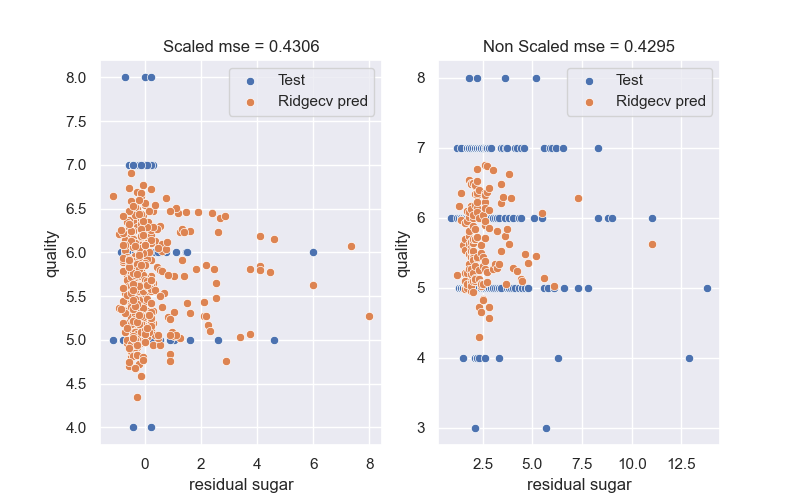

In [119]:

ypred      = pd.DataFrame( ridgecv.predict(Xtest_sc), columns=['quality'])
ypred_nosc = pd.DataFrame(ridgecv2.predict(X_test)  , columns=['quality'])

fig7, ax7 = plt.subplots(ncols=2,figsize=(8,5))

feat  = 'residual sugar'

testdf      = Xtest_sc.assign(quality = y_test) #.sort_values(by=feat,ascending=True)
preddf      = Xtest_sc.assign(quality = ypred) #.sort_values(by=feat,ascending=True)


testdf_nosc = X_test.assign(quality = y_test).sort_values(by=feat,ascending=True)
preddf_nosc = X_test.assign(quality = ypred_nosc).sort_values(by=feat,ascending=True)

sns.scatterplot(data=testdf,x=feat,y='quality',ax=ax7[0]).set_title('Scaled mse = {}'.format(mean_squared_error(y_test,ypred).round(4)))
sns.scatterplot(data=preddf,x=feat,y='quality',ax=ax7[0])

sns.scatterplot(data=testdf_nosc,x=feat,y='quality',ax=ax7[1]).set_title('Non Scaled mse = {}'.format(mean_squared_error(y_test,ypred_nosc).round(4)))
sns.scatterplot(data=preddf_nosc,x=feat,y='quality',ax=ax7[1])

ax7[0].legend(['Test','Ridgecv pred'])
ax7[1].legend(['Test','Ridgecv pred'])

The previous plot is an example of one of the features (residual sugar) against the quality of the wines. We can see that in both cases the mse of the model is nearly independent of the scaled or no scaled dataframe. Nevertheless, note that the x-axis between both cases; they are in the same order of magnitude so we have to show another feature like **total sulfur dioxide**.

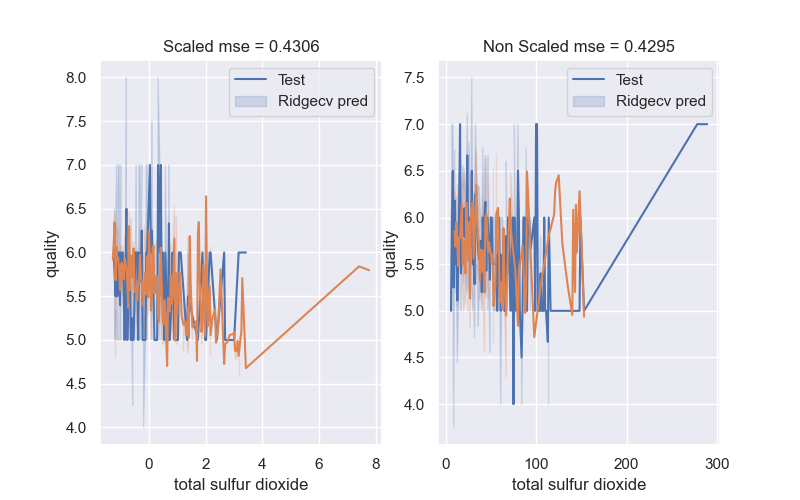

In [120]:

fig8, ax8 = plt.subplots(ncols=2,figsize=(8,5))

feat  = 'total sulfur dioxide'

sns.lineplot(data=testdf,x=feat,y='quality',ax=ax8[0]).set_title('Scaled mse = {}'.format(mean_squared_error(y_test,ypred).round(4)))
sns.lineplot(data=preddf,x=feat,y='quality',ax=ax8[0])

sns.lineplot(data=testdf_nosc,x=feat,y='quality',ax=ax8[1]).set_title('Non Scaled mse = {}'.format(mean_squared_error(y_test,ypred_nosc).round(4)))
sns.lineplot(data=preddf_nosc,x=feat,y='quality',ax=ax8[1])

ax8[0].legend(['Test','Ridgecv pred'])
ax8[1].legend(['Test','Ridgecv pred'])

--------------
--------------
--------------
--------------
# Removing nearly uncorrelated features and outliners from the model

(1599, 12)


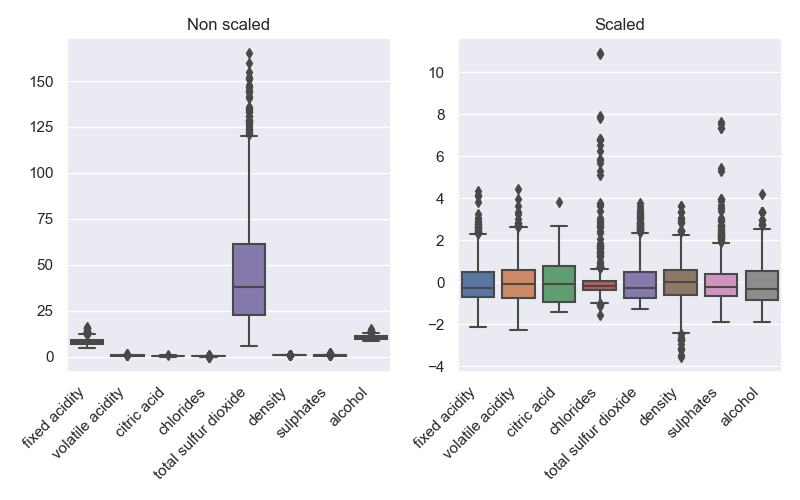

In [121]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df = pd.read_csv('winequality-red.csv')
# X = df.drop('quality',axis=1)
X = df.drop(['quality','pH','free sulfur dioxide','residual sugar'],axis=1)
y = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign0, axn0 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn0[0]).set_title('Non scaled');
axn0[0].set_xticklabels(axn0[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn0[1]).set_title('Scaled');
axn0[1].set_xticklabels(axn0[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()
print(df.shape)


**removing uncorrelated variables**

In [122]:
qual_corr = df.corr().abs().sort_values(by='quality',ascending=False)
corr_tol = 0.1
print('removing correlations bellow {}'.format(corr_tol))
qq = qual_corr[qual_corr['quality']<=corr_tol].index
df = df.drop(qq,axis=1)
df

removing correlations bellow 0.1


,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5
1,7.8,0.880,0.00,0.098,67.0,0.99680,0.68,9.8,5
2,7.8,0.760,0.04,0.092,54.0,0.99700,0.65,9.8,5
3,11.2,0.280,0.56,0.075,60.0,0.99800,0.58,9.8,6
4,7.4,0.700,0.00,0.076,34.0,0.99780,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,0.090,44.0,0.99490,0.58,10.5,5
1595,5.9,0.550,0.10,0.062,51.0,0.99512,0.76,11.2,6
1596,6.3,0.510,0.13,0.076,40.0,0.99574,0.75,11.0,6
1597,5.9,0.645,0.12,0.075,44.0,0.99547,0.71,10.2,5


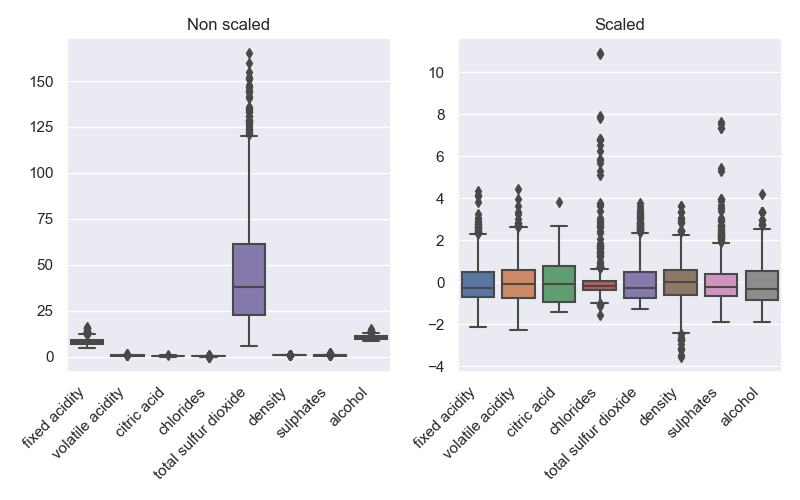

In [123]:

X = df.drop('quality',axis=1)
y = df['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign1, axn1 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn1[0]).set_title('Non scaled');
axn1[0].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn1[1]).set_title('Scaled');

axn1[1].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

**Removing the outliers in the DF**

In [124]:
dd = {}
for i in df.columns:  
    
    ff   = df[i]
    q1   = np.quantile(ff,0.25)
    q3   = np.quantile(ff,0.75)
    
    ir   = q3-q1
    atop = 1.2
    abot = 1.2
    topw = q3+atop*ir
    botw = q1-abot*ir
    ff   = ff[ df[i] < topw]
    ff   = ff[ df[i] > botw]
    dd[i] = ff
df_clean = pd.DataFrame(dd)
df_clean1 = df_clean.dropna()
display(df_clean1.head(5),df_clean1.shape)

,fixed acidity,volatile acidity,citric acid,chlorides,total sulfur dioxide,density,sulphates,alcohol,quality
0,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5.0
1,7.8,0.88,0.00,0.098,67.0,0.9968,0.68,9.8,5.0
2,7.8,0.76,0.04,0.092,54.0,0.9970,0.65,9.8,5.0
3,11.2,0.28,0.56,0.075,60.0,0.9980,0.58,9.8,6.0
4,7.4,0.70,0.00,0.076,34.0,0.9978,0.56,9.4,5.0


(1164, 9)

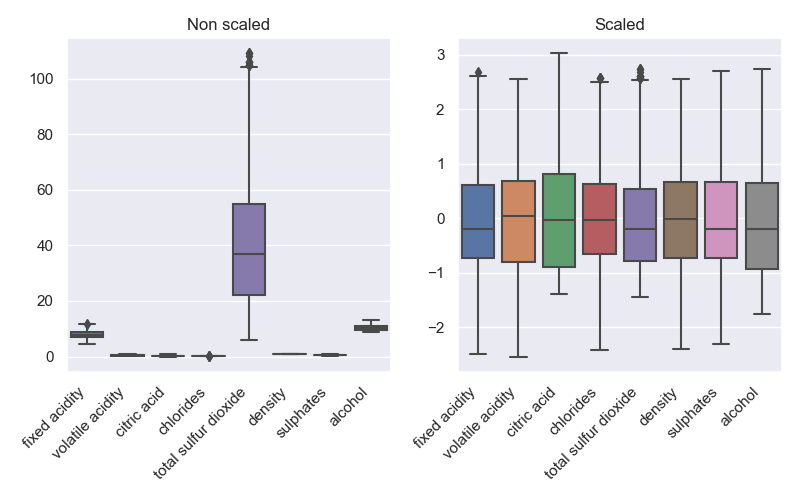

In [125]:


X = df_clean1.drop('quality',axis=1)
y = df_clean1['quality']

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.3, random_state = 63)

sc = StandardScaler()
Xtrain_sc  = pd.DataFrame(sc.fit_transform(X_train),columns=X.columns)
Xtest_sc   = pd.DataFrame(sc.transform(X_test),columns=X.columns)

# Xtrain_sc = X_train

fign1, axn1 = plt.subplots(ncols=2,figsize=(8,5))
sns.boxplot(data=X_train,ax= axn1[0]).set_title('Non scaled');
axn1[0].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
sns.boxplot(data=Xtrain_sc,ax=axn1[1]).set_title('Scaled');
axn1[1].set_xticklabels(axn1[0].get_xticklabels(),rotation=45,ha='right');
plt.tight_layout()

In [126]:
lambdas = lambdas
ridgecv = RidgeCV(cv=7,fit_intercept=True) 
ridgecv2 = RidgeCV(cv=7,fit_intercept=True) 

#Scaled model
model_ridgecv = ridgecv.fit(Xtrain_sc,y_train) 
#nonscaled model
model_ridgecv_noscaled = ridgecv2.fit(X_train,y_train) 

In [127]:
def report_regularization (model, X_test, y_test,observation=''):
    print('\n{}'.format(observation))
    print( 'Regularization parameters values: {0}' .format(model.alpha_))
    print( 'Final coefficients: \n{0}' .format(model.coef_))
    y_hat = model.predict(X_test)
    print( 'R-squared: {0}' .format(r2_score(y_test,y_hat).round(2)))
    print( 'Mean Squared Error: {0}' .format(mean_squared_error(y_test, y_hat).round(2)))

In [128]:
#Ridge CV report
report_regularization(ridgecv,Xtest_sc,y_test,observation='****************** Scaled')
report_regularization(model_ridgecv_noscaled,X_test,y_test,observation='****************** Non Scaled')


****************** Scaled
Regularization parameters values: 10.0
Final coefficients: 
[ 0.07749915 -0.16264387 -0.06031529  0.03065011 -0.04948503 -0.03901157
  0.19961006  0.25088881]
R-squared: 0.36
Mean Squared Error: 0.32

****************** Non Scaled
Regularization parameters values: 0.1
Final coefficients: 
[ 0.04797139 -1.11019213 -0.39665704  1.12524473 -0.00199774 -0.14372183
  1.68497632  0.28407331]
R-squared: 0.36
Mean Squared Error: 0.31


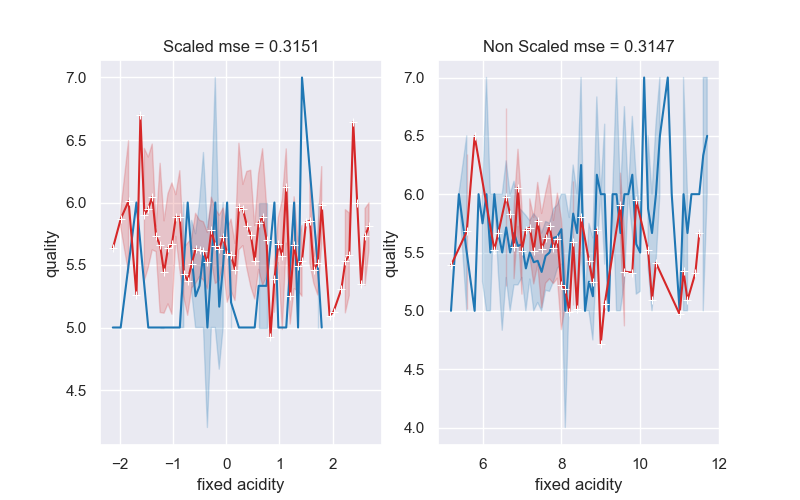

In [129]:
feat  = df.columns[0]

ypred3      = pd.DataFrame( ridgecv.predict(Xtest_sc), columns=['quality'])
ypred3_nosc = pd.DataFrame(ridgecv2.predict(X_test)  , columns=['quality'])

fign2, axn2 = plt.subplots(ncols=2,figsize=(8,5))



testdf      = Xtest_sc.assign(quality = y_test) #.sort_values(by=feat,ascending=True)
preddf      = Xtest_sc.assign(quality = ypred) #.sort_values(by=feat,ascending=True)


testdf_nosc = X_test.assign(quality = y_test) #.sort_values(by=feat,ascending=True)
preddf_nosc = X_test.assign(quality = ypred_nosc) #.sort_values(by=feat,ascending=True)

sns.lineplot(data=testdf,x=feat,y='quality',ax=axn2[0],color='tab:blue').set_title('Scaled mse = {}'.format(mean_squared_error(y_test,ypred3).round(4)))
sns.lineplot(data=preddf,x=feat,y='quality',ax=axn2[0],marker='+',color='tab:red')

sns.lineplot(data=testdf_nosc,x=feat,y='quality',ax=axn2[1],color='tab:blue').set_title('Non Scaled mse = {}'.format(mean_squared_error(y_test,ypred3_nosc).round(4)))
sns.lineplot(data=preddf_nosc,x=feat,y='quality',ax=axn2[1],marker='+',color='tab:red')

ax7[0].legend(['Test','Ridgecv pred'])
ax7[1].legend(['Test','Ridgecv pred'])